In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

Consider the next query: 
`SELECT SUM(B) FROM my_table WHERE A < X`

With late materialization, we only need to load the blocks of column B where at least one tuple passes the predicate. Let us build a small model that takes *block size, data distribution* and *predicate* as parameters to evaluate the expected number of blocks of column B that need to be loaded from the disk.

Let *p* be the probability of one tuple to pass the predicate. Then $(1 - p)^{block\_size}$ is the probability of all the tuples in the block not to pass the predicate. Thus, the probability of one particular block to be loaded is $1 - (1 - p)^{block\_size}$. And this number is also the expected part of blocks that need to be loaded.

We will check next distributions: uniform, normal, Cauchy, Poisson, geometric, exponential, binomial.

In [3]:
def expected_part_of_loaded_block(block_size, distrib, predicate, N=100000, discrete=False):
    r = distrib.rvs(size=N)
    p = np.mean(predicate(r))
    # plt.hist(r, density=True, alpha=0.4, bins=40)
    start = distrib.ppf(0.005)
    stop = distrib.ppf(0.995)

    if discrete:
        grid = np.arange(start=start, stop=stop+1, step=1)
        # plt.plot(grid, distrib.pmf(grid))
    else:
        grid = np.linspace(start=start, stop=stop, num=201)
        # plt.plot(grid, distrib.pdf(grid))
    # plt.xlim(start - 0.2, stop + 0.2)
    print('probability to pass the predicate: {}'.format(p))
    print('part of blocks to be loaded: {}'.format(1 - (1 - p)**block_size))
    return 1 - (1 - p)**block_size

def expected_part_of_loaded_block_int(block_size, distrib, predicate, N=100000, discrete=False):
    r = distrib.rvs(size=N)
    r = np.round(r)
    for item in r:
        if item < 0:
            item = 0
        if item > 100:
            item = 100
    p = np.mean(predicate(r))
    # plt.hist(r, density=True, alpha=0.4, bins=100)
    start = distrib.ppf(0.005)
    stop = distrib.ppf(0.995)

    if discrete:
        grid = np.arange(start=start, stop=stop+1, step=1)
        #plt.plot(grid, distrib.pmf(grid))
    else:
        grid = np.linspace(start=start, stop=stop, num=201)
        # plt.plot(grid, distrib.pdf(grid))
    # plt.xlim(start - 0.2, stop + 0.2)
    print('probability to pass the predicate: {}'.format(p))
    print('part of blocks to be loaded: {}'.format(1 - (1 - p)**block_size))
    return 1 - (1 - p)**block_size

## Unoform distribution

In [4]:
uniform_distrib = sps.uniform
predicate = lambda x: x < 0.05
expected_part_of_loaded_block(10, uniform_distrib, predicate)

probability to pass the predicate: 0.05021
part of blocks to be loaded: 0.4025852687399728


0.4025852687399728

In [5]:
uniform_distrib = sps.uniform(loc=0, scale=100)
predicate = lambda x: x < 5
expected_part_of_loaded_block_int(10, uniform_distrib, predicate)

probability to pass the predicate: 0.04482
part of blocks to be loaded: 0.367803329576159


0.367803329576159

## Normal distribution

In [6]:
norm_distrib = sps.norm(loc=0, scale=1)
predicate = lambda x: x > 1
expected_part_of_loaded_block(10, norm_distrib, predicate)

probability to pass the predicate: 0.16126
part of blocks to be loaded: 0.8277046515654862


0.8277046515654862

In [7]:
norm_distrib = sps.norm(loc=50, scale=20)
predicate = lambda x: x < 5
expected_part_of_loaded_block_int(10, norm_distrib, predicate)

probability to pass the predicate: 0.01146
part of blocks to be loaded: 0.10886711247681824


0.10886711247681824

In [8]:
norm_distrib = sps.norm(loc=0, scale=1)
predicate = lambda x: x > 0.5
expected_part_of_loaded_block(10, norm_distrib, predicate)

probability to pass the predicate: 0.30719
part of blocks to be loaded: 0.974523399526315


0.974523399526315

## Cauchy distribution

In [9]:
cauchy_distrib = sps.cauchy(loc=0, scale=1)
predicate = lambda x: x > 10
expected_part_of_loaded_block(10, cauchy_distrib, predicate)

probability to pass the predicate: 0.03153
part of blocks to be loaded: 0.2741251946907255


0.2741251946907255

In [12]:
cauchy_distrib = sps.cauchy(loc=50, scale=15)
predicate = lambda x: x < 5
expected_part_of_loaded_block_int(10, cauchy_distrib, predicate)

probability to pass the predicate: 0.09971
part of blocks to be loaded: 0.650196409978132


0.650196409978132

In [13]:
cauchy_distrib = sps.cauchy(loc=0, scale=1)
predicate = lambda x: x > 5
expected_part_of_loaded_block(10, cauchy_distrib, predicate)

probability to pass the predicate: 0.06246
part of blocks to be loaded: 0.47531571217989455


0.47531571217989455

In [14]:
cauchy_distrib = sps.cauchy(loc=0, scale=1)
predicate = lambda x: x > 2
expected_part_of_loaded_block(10, cauchy_distrib, predicate)

probability to pass the predicate: 0.1472
part of blocks to be loaded: 0.7965433371416669


0.7965433371416669

## Poisson distribution

In [15]:
poisson_distrib = sps.poisson(loc=-350, mu=400)
predicate = lambda x: x < 5
expected_part_of_loaded_block(10, poisson_distrib, predicate, discrete=True)

probability to pass the predicate: 0.01005
part of blocks to be loaded: 0.096074579820139


0.096074579820139

In [16]:
poisson_distrib = sps.poisson(10)
predicate = lambda x: x > 15
expected_part_of_loaded_block(10, poisson_distrib, predicate, discrete=True)

probability to pass the predicate: 0.04943
part of blocks to be loaded: 0.39766092405220654


0.39766092405220654

## Geometric distribution

In [17]:
geom_distrib = sps.geom(0.5)
predicate = lambda x: x > 3
expected_part_of_loaded_block(10, geom_distrib, predicate, discrete=True)

probability to pass the predicate: 0.12418
part of blocks to be loaded: 0.7344486069216366


0.7344486069216366

In [18]:
geom_distrib = sps.geom(0.7)
predicate = lambda x: x > 3
expected_part_of_loaded_block(10, geom_distrib, predicate, discrete=True)

probability to pass the predicate: 0.02689
part of blocks to be loaded: 0.23858863424983867


0.23858863424983867

In [19]:
geom_distrib = sps.geom(0.2)
predicate = lambda x: x > 3
expected_part_of_loaded_block(10, geom_distrib, predicate, discrete=True)

probability to pass the predicate: 0.51246
part of blocks to be loaded: 0.9992412433159077


0.9992412433159077

## Exponential distribution

In [20]:
exp_distrib = sps.expon(1)
predicate = lambda x: x > 2
expected_part_of_loaded_block(10, exp_distrib, predicate)

probability to pass the predicate: 0.36655
part of blocks to be loaded: 0.9895978429880051


0.9895978429880051

In [21]:
exp_distrib = sps.expon(1)
predicate = lambda x: x > 3
expected_part_of_loaded_block(10, exp_distrib, predicate)

probability to pass the predicate: 0.13229
part of blocks to be loaded: 0.7580386352310162


0.7580386352310162

In [22]:
exp_distrib = sps.expon(0.1)
predicate = lambda x: x > 3
expected_part_of_loaded_block(10, exp_distrib, predicate)

probability to pass the predicate: 0.056
part of blocks to be loaded: 0.4380211865948278


0.4380211865948278

In [23]:
exp_distrib = sps.expon(10)
predicate = lambda x: x > 13
expected_part_of_loaded_block(10, exp_distrib, predicate)

probability to pass the predicate: 0.05017
part of blocks to be loaded: 0.4023336223914652


0.4023336223914652

## Binomial distribution

In [24]:
binom_distrib = sps.binom(n=10, p=0.5)
predicate = lambda x: x > 7
expected_part_of_loaded_block(10, binom_distrib, predicate, discrete=True)

probability to pass the predicate: 0.05314
part of blocks to be loaded: 0.4207611239670209


0.4207611239670209

In [25]:
binom_distrib = sps.binom(n=15, p=0.6)
predicate = lambda x: x > 7
expected_part_of_loaded_block(10, binom_distrib, predicate, discrete=True)

probability to pass the predicate: 0.78664
part of blocks to be loaded: 0.9999998045075331


0.9999998045075331

In [26]:
binom_distrib = sps.binom(n=100, p=0.1)
predicate = lambda x: x < 7
expected_part_of_loaded_block(10, binom_distrib, predicate, discrete=True)

probability to pass the predicate: 0.11703
part of blocks to be loaded: 0.7119555701415539


0.7119555701415539

## Heatmap
Proceed to finding the values of selectivity and block size that lead to more skewed data access.

We evaluate this for normal distribution because it naturally represents things in real life.

In [27]:
def expected_part_of_loaded_blocks(block_size, distrib, bound, N=100000, discrete=False, print_all=True):
    p = distrib.cdf(bound)
    
    if print_all:
        print('blocksize: {}, bound: {}, part of blocks to be loaded: {}'.format(block_size, 
                                                                             bound, 1 - (1 - p)**block_size))
    return 1 - (1 - p)**block_size

In [28]:
norm_distrib = sps.norm(loc=0, scale=1)
predicate = lambda x: x > 1
expected_part_of_loaded_block(10, norm_distrib, predicate)

probability to pass the predicate: 0.15986
part of blocks to be loaded: 0.8248070504623441


0.8248070504623441

In [29]:
bound_range = np.round(np.arange(start=-4.4, stop=-2.6, step=0.05), 2)
block_size_range = np.round(np.geomspace(2**10, 2**27, 18))

data = []
for bound in bound_range:
    data.append([])
    for block_size in block_size_range:
        curr = expected_part_of_loaded_blocks(block_size, norm_distrib, bound, print_all=False)
        data[-1].append(curr)

Text(0.5, 1.0, 'Part of blocks to be loaded')

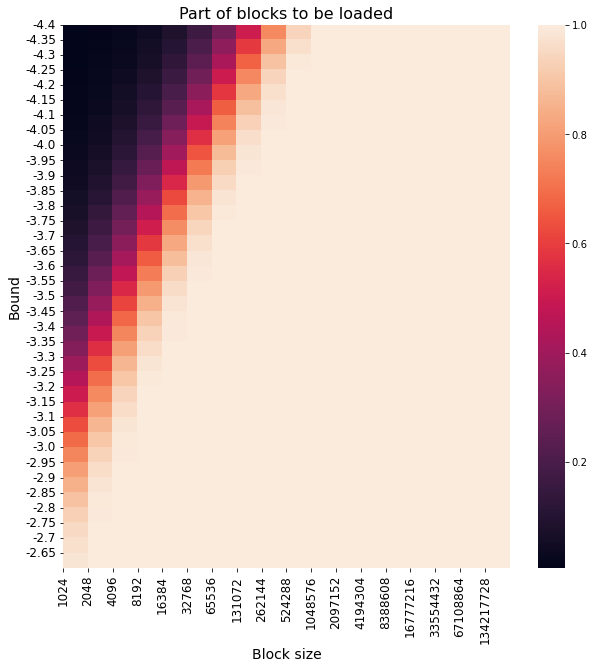

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(data)

xticks = np.arange(0, len(block_size_range), 1)
plt.xticks(ticks=xticks, labels=[str(int(val)) for val in block_size_range], rotation=90, fontsize=12)
yticks = np.arange(0, len(bound_range), 1)
plt.yticks(ticks=yticks, labels=[str(round(val, 2)) for val in bound_range], rotation=0, fontsize=12)
plt.xlabel('Block size', fontsize=14)
plt.ylabel('Bound', fontsize=14)
plt.title('Part of blocks to be loaded', fontsize=16)

Let us take a look at the top-left corner of the plot above.

Text(0.5, 1.0, 'Part of blocks to be loaded')

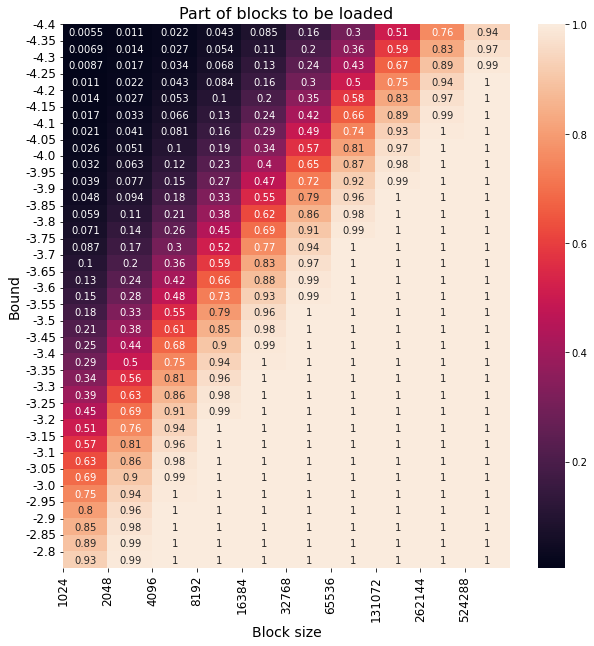

In [31]:
bound_range = np.round(np.arange(start=-4.4, stop=-2.8, step=0.05), 2)
block_size_range = np.round(np.geomspace(2**10, 2**19, 10))

data = []
selectivity = []
for bound in bound_range:
    curr_selectivity = expected_part_of_loaded_blocks(1, norm_distrib, bound, print_all=False)
    selectivity.append(curr_selectivity)
    data.append([])
    for block_size in block_size_range:
        curr = expected_part_of_loaded_blocks(block_size, norm_distrib, bound, print_all=False)
        data[-1].append(curr)
        
plt.figure(figsize=(10, 10))
sns.heatmap(data, annot=True)

xticks = np.arange(0, len(block_size_range), 1)
plt.xticks(ticks=xticks, labels=[str(int(val)) for val in block_size_range], rotation=90, fontsize=12)
yticks = np.arange(0, len(bound_range), 1)
plt.yticks(ticks=yticks, labels=[str(round(val, 2)) for val in bound_range], rotation=0, fontsize=12)
plt.xlabel('Block size', fontsize=14)
plt.ylabel('Bound', fontsize=14)
plt.title('Part of blocks to be loaded', fontsize=16)

Let's look at the probability of loading a particular block with fixed selectivity.

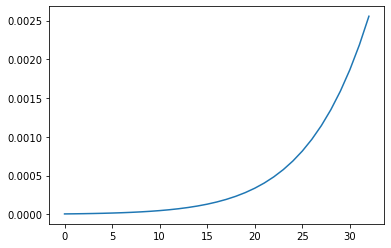

In [32]:
ps = [expected_part_of_loaded_blocks(1, norm_distrib, bound, print_all=False) for bound in bound_range]
plt.plot(ps)

## Trying more realistic distributions
Let us try a mix of normal distributions. Imagine data discribing the search queries about some companies. Companies gain popularity and then lose it.Thus the timestamps of queries may be assumed to be distributed normally with mean corresponding to the peak of company's popularity. We will consider the situation with a mix of 10 to 20 normal distributions with different mean values and variences. The probability to fit the predicate will be measured empirically.

In [33]:


class MixOfNormDistributions:
    def __init__(self, means, variances):
        self.means = means
        self.variances = variances
        self.n = len(means)
        
    def generate(self, block_num, block_size):
        r = np.array([])
        for i in range(block_num):
            j = i % self.n
            tmp = sps.norm(loc=self.means[j], scale=self.variances[j]).rvs(size=block_size)
            r = np.concatenate([r, tmp])
        return r
    
    def generate_blocks(self, block_num, block_size):
        r = []
        for i in range(block_num):
            j = i % self.n
            tmp = sps.norm(loc=self.means[j], scale=self.variances[j]).rvs(size=block_size)
            r.append(tmp)
        return r
    
    def show_hist(self, block_num, block_size):
        plt.figure(figsize=(10, 4))
        num = (block_num * block_size) / self.n
        for j in range(self.n):
            r = sps.norm(loc=self.means[j], scale=self.variances[j]).rvs(size=int(num))
            plt.hist(r, alpha=0.2, bins=100, density=True)
        r = self.generate(block_num, block_size)
        plt.hist(r, alpha=0.2, bins=100, density=True)
        
    def empirical_selectivity(self, bound):
        predicate = lambda x: x < bound
        r = self.generate(int(1e3), int(1e3))
        return np.mean(predicate(r))
    
    def _expected_part_of_loaded_blocks(self, block_size, distrib, bound):
        p = distrib.cdf(bound)
        return 1 - (1 - p)**block_size
    
    def expected_part_of_loaded_blocks(self, block_size, bound):
        sum_of_ps = 0
        for i in range(self.n):
            sum_of_ps += self._expected_part_of_loaded_blocks(block_size, 
                                                        sps.norm(loc=self.means[i], scale=self.variances[i]),
                                                        bound)
        return sum_of_ps / self.n
            

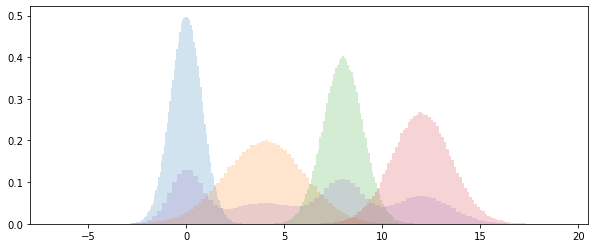

In [34]:
means = [0, 4, 8, 12]
variances = [0.8, 2, 1, 1.5]
mix = MixOfNormDistributions(means, variances)
mix.generate(2, 2)
mix.show_hist(1000, 1024)

Let's ensure that our way of determining the selectivity works.

In [35]:
means = [0]
variances = [1]
mix = MixOfNormDistributions(means, variances)
print(mix.empirical_selectivity(-1))
print(sps.norm.cdf(-1))

0.15915
0.15865525393145707


In [36]:
means = [0, 2, 4]
variances = [1, 1, 1]
mix = MixOfNormDistributions(means, variances)
print('expected part of loaded blocks: {}'.format(mix.expected_part_of_loaded_blocks(1024, -1.5)))
print('empirical selectivity: {}'.format(mix.empirical_selectivity(-1.5)))

expected part of loaded blocks: 0.4040019374419715
empirical selectivity: 0.022661


Let us play around with different values of mean and variance, and different numbers of distributions.

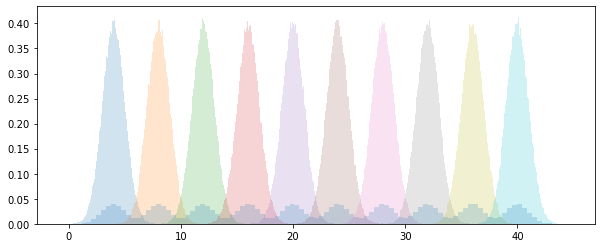

In [37]:
n = 10
means = np.linspace(4, 4 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)
mix.show_hist(1000, 1024)

In [38]:
bound_range = np.arange(start=1, stop=24, step=1)
block_size_range = np.round(np.geomspace(2**10, 2**27, 18))

In [43]:
def heatmap_from_mix(bound_range, block_size_range, mix):
    data = []
    selectivity = []
    for i, bound in enumerate(bound_range):
        curr_selectivity = mix.empirical_selectivity(bound)
        selectivity.append(curr_selectivity)
        data.append([])
        for block_size in block_size_range:
            curr = mix.expected_part_of_loaded_blocks(block_size, bound)
            data[-1].append(curr)

    plt.figure(figsize=(15, 10))
    sns.heatmap(data, annot=True, fmt='0.3g')

    xticks = np.arange(0, len(block_size_range), 1)
    plt.xticks(ticks=xticks, labels=[str(int(val)) for val in block_size_range], rotation=90, fontsize=12)
    yticks = np.arange(0, len(bound_range), 1)
    plt.yticks(ticks=yticks, labels=[str(round(val, 4)) for val in selectivity], rotation=0, fontsize=12)
    plt.xlabel('Block size', fontsize=14)
    plt.ylabel('Selectivity', fontsize=14)
    plt.title('Part of blocks to be loaded', fontsize=16)

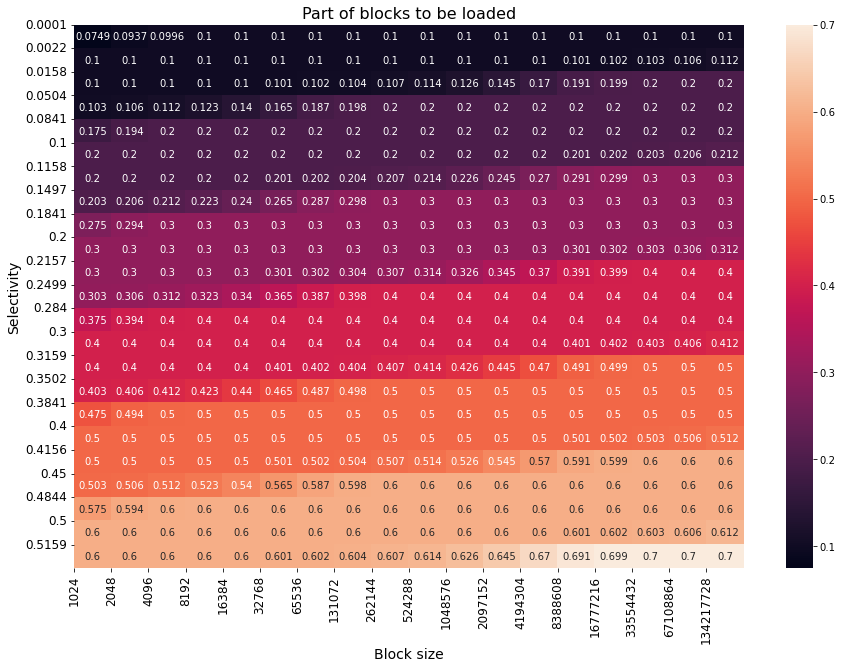

In [44]:
heatmap_from_mix(bound_range, block_size_range, mix)

This plot shows that the dependency of the expected part of blocks to be loaded on the selectivity is much more expressed than on the block size. That is because "humps" of the normal distributions are well separated. If the bound of the query is close to the $means[i]$, then all the blocks with distributions $means[j]$ for $j < i$ are almost surely loaded, while all the blocks with distributions $means[j]$ for $j > i$ are not. So the block size affects the number of blocks with distribution $i$  loaded, which is significantly smaller then total number of blocks.

That's why we can consider smaller range of block sizes, say, with 4-fold increment.

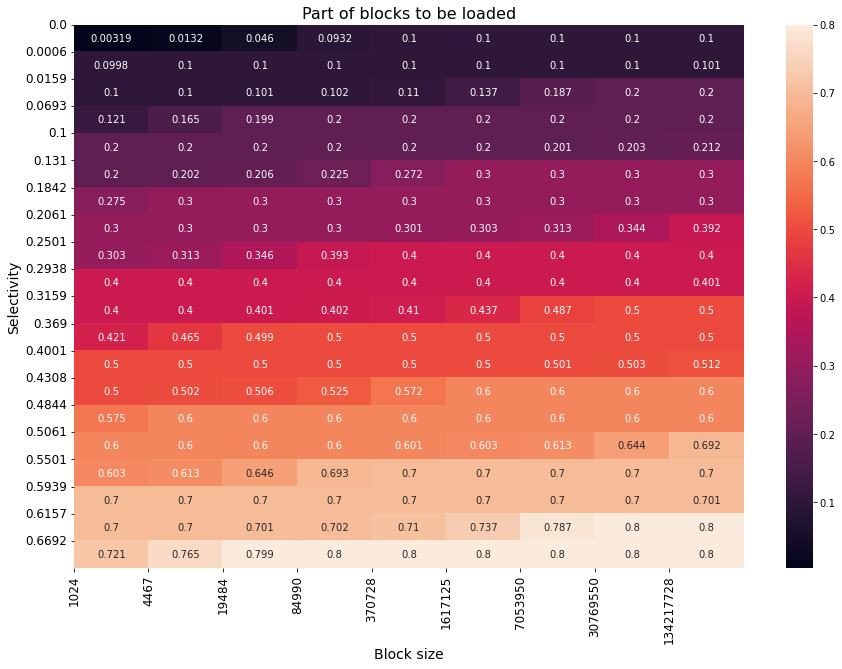

In [45]:
bound_range = np.arange(start=0, stop=30, step=1.5)
block_size_range = np.round(np.geomspace(2**10, 2**27, 9))
heatmap_from_mix(bound_range, block_size_range, mix)

Let's try other mixes of normal distributions. Firstly let's move to having less peaks.

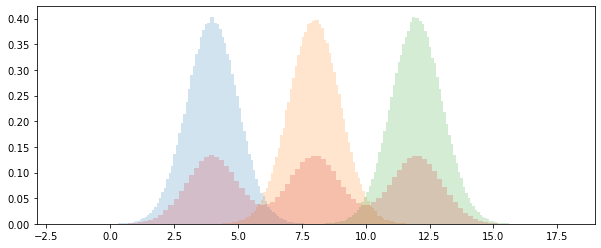

In [46]:
n = 3
means = np.linspace(4, 4 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)
mix.show_hist(1000, 1024)

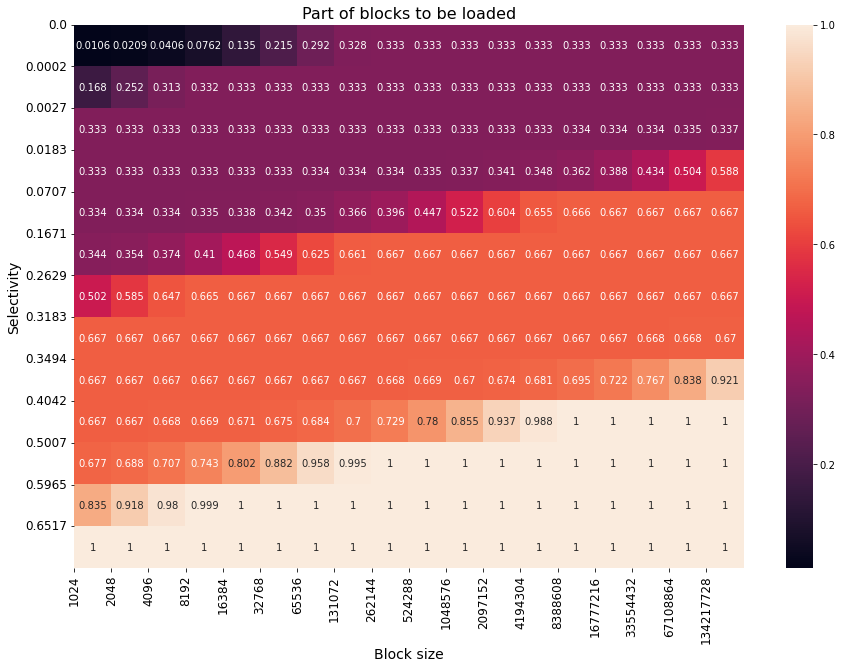

In [47]:
bound_range = np.arange(start=0, stop=10, step=0.8)
block_size_range = np.round(np.geomspace(2**10, 2**27, 18))
heatmap_from_mix(bound_range, block_size_range, mix)

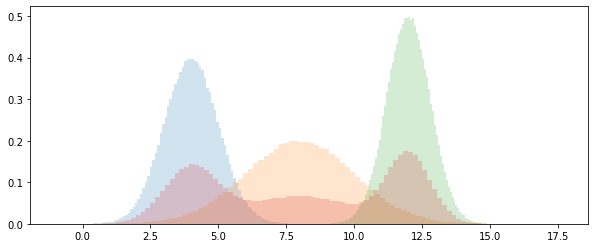

In [48]:
n = 3
means = np.linspace(4, 4 * n, n)
variances = [1, 2, 0.8]
mix = MixOfNormDistributions(means, variances)
mix.show_hist(1000, 1024)

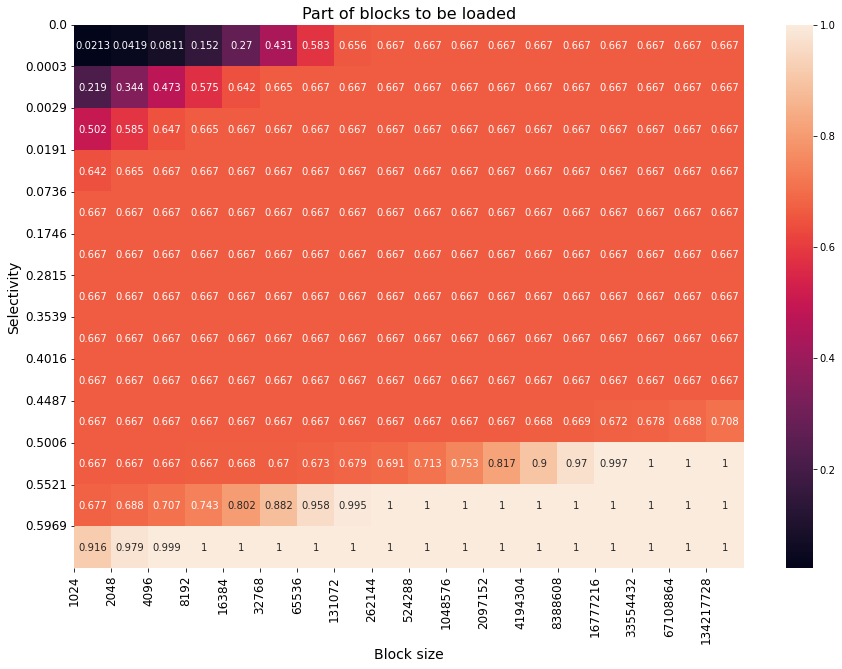

In [49]:
bound_range = np.arange(start=0, stop=10, step=0.8)
block_size_range = np.round(np.geomspace(2**10, 2**27, 18))
heatmap_from_mix(bound_range, block_size_range, mix)

Let's try the case when "humps" are closer to each other.

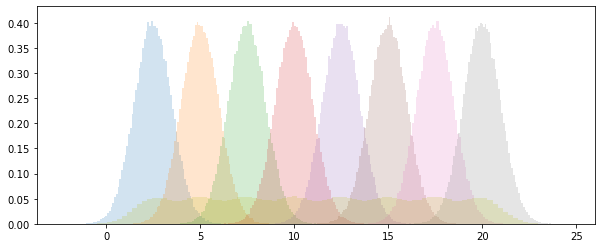

In [50]:
n = 8
means = np.linspace(2.5, 2.5 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)
mix.show_hist(1000, 1024)

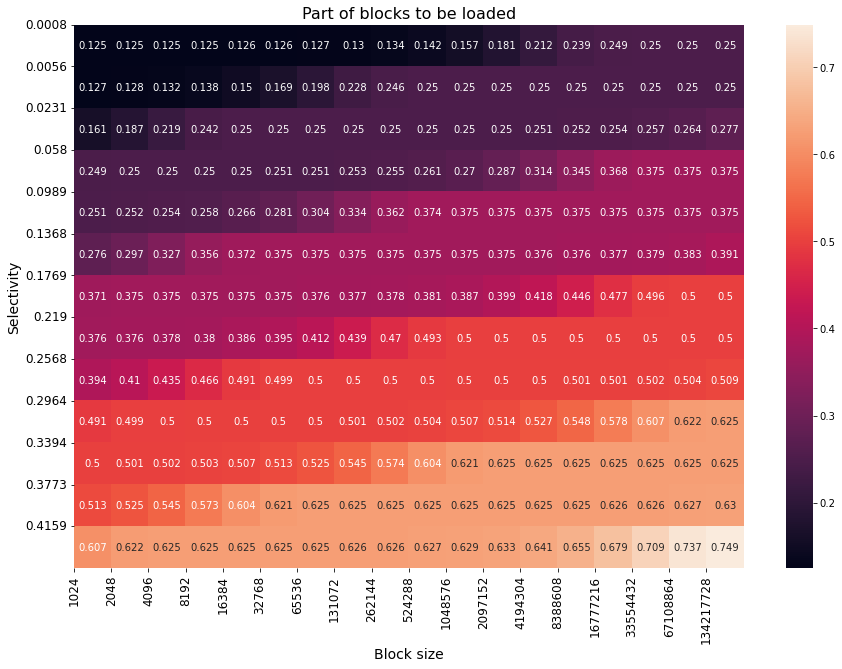

In [51]:
bound_range = np.arange(start=0, stop=10, step=0.8)
block_size_range = np.round(np.geomspace(2**10, 2**27, 18))
heatmap_from_mix(bound_range, block_size_range, mix)

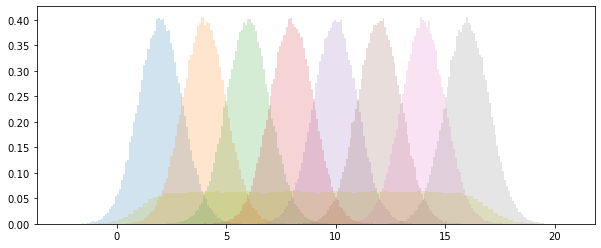

In [52]:
n = 8
means = np.linspace(2, 2 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)
mix.show_hist(1000, 1024)

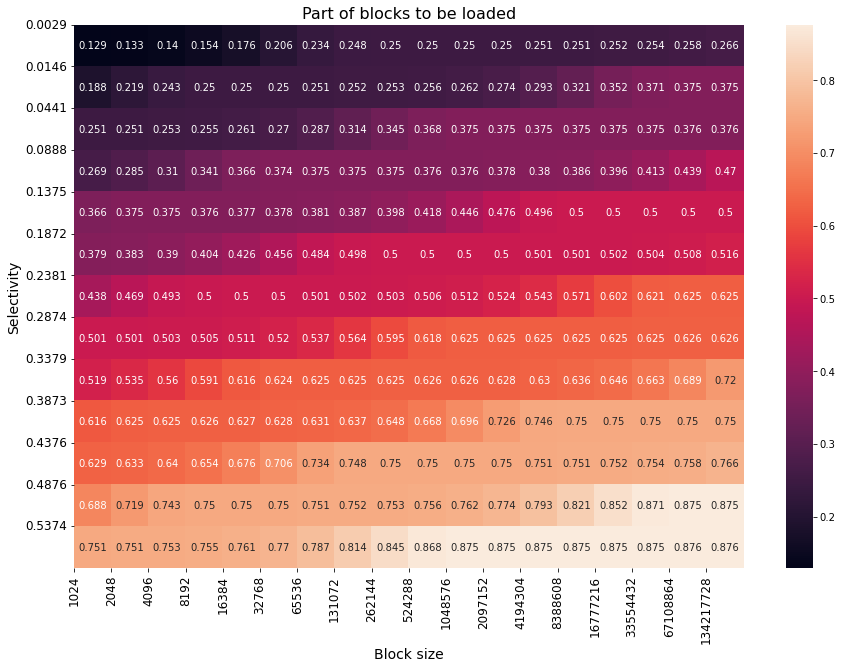

In [53]:
bound_range = np.arange(start=0, stop=10, step=0.8)
block_size_range = np.round(np.geomspace(2**10, 2**27, 18))
heatmap_from_mix(bound_range, block_size_range, mix)

What we see is that the more the distributions overlap the more the trends observed are similar to those in the case of one distribution.

## Adversarial cases for RoundRobin strategy
RoundRobin strategy leverages parallelism by using multiple disks. On the stage of checking the predicate for column A it utilises all the disks equally. But when scanning required values from column B, it might appear to be not the most beneficial strategy. For example, this can happen if we only need to load the blocks from the first disk.

In [54]:
def required_blocks_per_disk(r, n, upper_bound):
    arr = np.zeros(n)
    for i in range(len(r)):
        at_least_one_passes = False
        for item in r[i]:
            if item < upper_bound:
                at_least_one_passes = True
        if at_least_one_passes:
            arr[i % n] += 1
    return arr

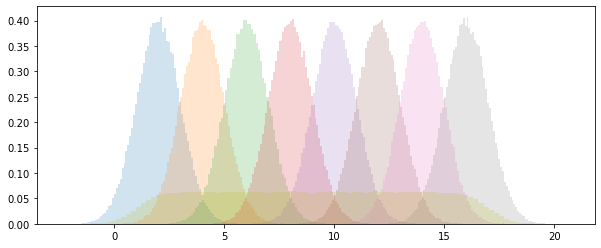

In [55]:
n = 6
means = np.linspace(8, n * 8, n)
variances = np.ones(n)

mix.show_hist(1000, 1024)

Let's evaluate what blocks mostly pass the predicate in the previous case.  

In [56]:
r = mix.generate_blocks(1024, 4096 * 16)
upper_bound = 8

required_blocks_per_disk(r, n, upper_bound)

array([128., 122., 128., 125., 128., 122.])

The next case demonstrates the possibility of blocks being equally distributed between two disks if RoundRobin strategy is used.

array([171.,   0.,   0., 171.,   0.,   0.])

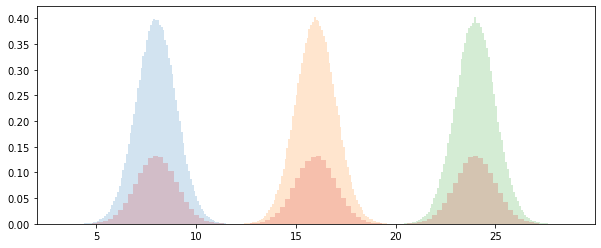

In [57]:
n = 6
means = np.linspace(8, 4 * n, n // 2)
variances = np.ones(n // 2)
mix = MixOfNormDistributions(means, variances)

mix.show_hist(1000, 1024)
r = mix.generate_blocks(1024, 4096 * 16)
upper_bound = 8

required_blocks_per_disk(r, n, upper_bound)